In [3]:
import json
import pandas as pd
import numpy as np
from scipy.sparse import csr_matrix

import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
bizPATH = 'data/yelp_dataset/yelp_academic_dataset_business.json'
revPATH = 'data/yelp_dataset/yelp_academic_dataset_review.json'
userPATH = 'data/yelp_dataset/yelp_academic_dataset_user.json'
covidPATH = 'data/covid_19_dataset_2020_06_10/yelp_academic_dataset_covid_features.json'

In [5]:
class Business:
    
    def __init__(self, business_id, name, address, coordinate, stars, review_count, attributes, categories):
        self.business_id = business_id
        self.name = name
        self.address = address
        self.coordinate = coordinate
        self.stars = stars
        self.review_count = review_count
        self.attributes = attributes
        self.categories = categories
        
    def __repr__(self):
        return (
            f"Address: {self.address}\nCoordinate: {self.coordinate}\nStars: {self.stars}\nCategories: {self.categories}"
        )
    
    
def BusinessDecoder(obj):
    
    address = f"{obj['address']} {obj['city']} {obj['state']} {obj['postal_code']}"
    coordinate = (obj['latitude'], obj['longitude'])
    
    return Business(obj['business_id'], obj['name'], address, coordinate, obj['stars'], obj['review_count'], 
                    obj['attributes'], obj['categories'])

In [6]:
# first extracting all the biz id within 'bar' category and save it into a dict
# because dict is implemented in hashtable with mostly O(1) look up time


def bizCatFilter(path, cat = 'bar'):

    bizID = {}
    nameMapper = {}

    with open(path, 'r') as infile:
        for line in infile:
            
            data = json.loads(line)
            
            if data['categories']:
                if cat.lower() in data['categories'].lower():
                    if data['review_count'] >= 10: 
                        
                        nameMapper[data['name']] = data['business_id']
                        bizID[data['business_id']] = BusinessDecoder(data)
                        
    return bizID, nameMapper

In [11]:
len(bizID)

15344

In [9]:
bizID, nameMapper = bizCatFilter(bizPATH, cat = 'bar') 

In [10]:
path = revPATH
# stop = 100000

reviews = list()
with open(path, 'r') as infile:
    for i, line in enumerate(infile):
#         if i%(stop)==0:
#             print(i)
#         if i == stop:
#             break
            
        data = json.loads(line)
        
        if(data['business_id'] in bizID):
            
#             review_id = data['review_id']
            user_id = data['user_id']
            business_id = data['business_id']
            stars = data['stars']
            date = data['date']
#             text = data['text']
#             useful = data['useful']
#             funny = data['funny']
#             cool = data['cool']
            
            reviews.append([user_id, business_id, stars, date])
            #[review_id, user_id, business_id, stars, date, text, useful, funny, cool])
            

df = pd.DataFrame(reviews, columns = ['user_id', 'business_id', 'stars', 'date'])
df.date = pd.to_datetime(df.date)
df = df[df['date'] > '2016']
df = df.drop(columns='date')
#['review_id', 'user_id', 'business_id', 'stars', 'date', 'text', 'useful', 'funny', 'cool'])

In [8]:
df.shape

NameError: name 'df' is not defined

In [13]:
df.user_id.nunique()

573472

In [11]:
df_2 = df.drop_duplicates(subset=['business_id', 'user_id'], keep='last')

In [12]:
df_2.shape

(1162850, 3)

In [13]:
treshold = 10
df_2 = df_2.groupby('user_id').filter(lambda x : len(x) >= treshold)
df_2 = df_2.groupby('business_id').filter(lambda x : len(x) >= treshold)

In [14]:
df_2.shape

(222118, 3)

In [15]:
revs = df_2.pivot(
    index = 'business_id',
    columns = 'user_id',
    values = 'stars'
).fillna(0)

In [28]:
((revs != 0).sum() <10).sum()

1950

In [29]:
revs.shape

(6197, 12680)

In [16]:
#scipy sparse matrix used to avoid improve efficiency
matMapper = {v:k for k, v in enumerate(revs.index)}
mat_revs = csr_matrix(revs.values)

In [26]:
(revs['zzKsgIF472IyDpJxmHDIpw'] != 0).sum()

3

In [40]:
revs

user_id,--2HUmLkcNHZp0xw6AMBPg,--BumyUHiO_7YsHurb9Hkw,--Nnm_506G_p8MxAOQna5w,--Qh8yKWAvIP4V4K8ZPfHA,--YhjyV-ce1nFLYxP49C5A,--ZNfWKj1VyVElRx6-g1fg,--cd_gA-9Q8gM9P2cTxEsQ,-0-hVEpwWEcJLJoGq3rE3g,-0Xu57zrI3Rxi8wGZsnWKQ,-0b84SUGVN0YkG5j2MCmBw,...,zy4A7504SezncCAcotMv4g,zyMB50UtmEuQf-1VUKxZxQ,zyebSPCZLUZHapi-dSHU5Q,zyg4-MFtfPWmwucVazSjfw,zyh_AzbO1JNnhywem3hUPg,zynfOy36AZ0WsoGUYAjQaA,zz25_Dsf99KnwTpdl4-PDQ,zzKsgIF472IyDpJxmHDIpw,zzmhLxcZ4XZQyz95c_KbOA,zzo--VpSQh8PpsGVeMC1dQ
business_id,,,,,,,,,,,,,,,,,,,,,
--FBCX-N37CMYDfs790Bnw,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
--I7YYLada0tSLkORTHb5Q,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
--cjBEbXMI2obtaRHNSFrA,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
-01XupAWZEXbdNbxNg5mEg,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
-0NrB58jqKqJfuUCDupcsw,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
zxsktAMsVBKj2PvvCV11UQ,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
zyPGYeXF4XKCqNN1pjFWhg,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
zyw5DjrRks7a8OhmBsgCQQ,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [38]:
mat_revs

<6197x12680 sparse matrix of type '<class 'numpy.float64'>'
	with 222118 stored elements in Compressed Sparse Row format>

# CF K-NN model

In [110]:
from sklearn.neighbors import NearestNeighbors

In [ ]:
# making model class
knn = NearestNeighbors(metric='cosine', algorithm='brute', n_neighbors=20, n_jobs=-1)

# fit the sparse matrix 
knn.fit(mat_revs)

In [276]:
def make_recommendation(model, data,  nameMapper, matMapper, bizID, fav_bar, n_recommendations):
    
    #fit
    model.fit(data)
    
    print(f"You favorite bar is: {fav_bar}.")
    print(bizID[nameMapper[fav_bar]])
    print('>'*10)
    
    bar_ID = nameMapper[fav_bar]
    
    print('Recommendation system starts to make inference')
    print('......\n')
    distances, indices = model.kneighbors(data[matMapper[bar_ID]], n_neighbors = n_recommendations+1)
    
    raw_recommends = sorted(list(zip(indices.squeeze().tolist(), distances.squeeze().tolist())),
                           key=lambda x:x[1])[:0:-1]
    
    #get reverse mappper
    reverse_mapper = {v: k for k, v in matMapper.items()}
    
    #print recommendations
    print(f'Recommendations for customers at {fav_bar}:')
    for i, (idx, dist) in enumerate(raw_recommends):
        match = bizID[reverse_mapper[idx]]
        print(f'{i+1} : {match.name, dist}')
        print(match)
        print('='*20)

In [288]:
# np.random.seed(20)
idx = revs.index[np.random.randint(revs.shape[0])]
name = bizID[idx].name
print(name)

Tarbell's The Tavern


In [289]:
bizID[idx]

Address: 3209 E Camelback Rd Phoenix AZ 85018
Coordinate: (33.5091229429, -112.0126287829)
Stars: 4.0
Categories: Cocktail Bars, American (Traditional), Bars, Nightlife, Wine Bars, Lounges, American (New), Mexican, Restaurants

In [290]:
make_recommendation(
    model = knn, 
    data = mat_revs, 
    nameMapper = nameMapper, 
    matMapper = matMapper,
    bizID = bizID, 
    fav_bar = name, 
    n_recommendations = 10)

You favorite bar is: Tarbell's The Tavern.
Address: 3209 E Camelback Rd Phoenix AZ 85018
Coordinate: (33.5091229429, -112.0126287829)
Stars: 4.0
Categories: Cocktail Bars, American (Traditional), Bars, Nightlife, Wine Bars, Lounges, American (New), Mexican, Restaurants
>>>>>>>>>>
Recommendation system starts to make inference
......

Recommendations for customers at Tarbell's The Tavern:
1 : ('Hillstone Restaurant', 0.8839822506321126)
Address: 2650 E Camelback Rd Phoenix AZ 85016
Coordinate: (33.5101434, -112.0243027)
Stars: 4.0
Categories: Nightlife, Restaurants, Sushi Bars, Jazz & Blues, Arts & Entertainment, Steakhouses, American (New)
2 : ('Mora Italian', 0.8838927214306364)
Address: 5651 N 7th St Phoenix AZ 85014
Coordinate: (33.5198524, -112.064637)
Stars: 4.0
Categories: Bars, Nightlife, Pizza, Salad, Restaurants, Italian
3 : ('CEDAR ROOM Fine Cigars & Lounge', 0.8821757045026125)
Address: 20715 N Pima Rd, Ste F100 Scottsdale AZ 85255
Coordinate: (33.6738829, -111.8881123)
Star

In [1]:
revs

NameError: name 'revs' is not defined

# Covid Data

In [27]:
covidPATH = 'data/covid_19_dataset_2020_06_10/yelp_academic_dataset_covid_features.json'

In [30]:
file = open(covidPATH)

In [38]:
data = json.loads(file.readline())

In [252]:
data = pd.read_json(covidPATH, lines=True)

In [258]:
data[data.highlights != 'FALSE'].highlights

6         [{"identifier":"remote_services_during_covid_1...
225       [{"identifier":"remote_services_during_covid_1...
230       [{"identifier":"online_classes_during_covid_19...
423       [{"identifier":"gift_cards_during_covid_19","p...
684       [{"identifier":"virtual_estimates_during_covid...
                                ...                        
209696    [{"identifier":"curbside_pickup_during_covid_1...
209728    [{"identifier":"takeout_during_covid_19","para...
209767    [{"identifier":"gift_cards_during_covid_19","p...
209771    [{"identifier":"remote_services_during_covid_1...
209775    [{"identifier":"curbside_drop_off_during_covid...
Name: highlights, Length: 7119, dtype: object

In [337]:
(data != 'FALSE').sum()

business_id                 209795
highlights                    7119
delivery or takeout          66231
Grubhub enabled              17993
Call To Action enabled       54067
Request a Quote Enabled       2448
Covid Banner                 14226
Temporary Closed Until        1381
Virtual Services Offered      4222
dtype: int64

In [338]:
data

,business_id,highlights,delivery or takeout,Grubhub enabled,Call To Action enabled,Request a Quote Enabled,Covid Banner,Temporary Closed Until,Virtual Services Offered
0,9kXRUIkwdDtnAPO6tVo51g,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE
1,H6D5HOTfMjrZt7r1EObZ1g,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE
2,FYddq7fUtzobZcw4jOJgVA,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE
3,c75jLTjlgA9q3gImLEGT6w,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE
4,YfzPiY50h_10Sjlg3mnNWQ,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE
...,...,...,...,...,...,...,...,...,...
209790,PAuSe4-JzDLq6YO6OKPeTg,FALSE,FALSE,FALSE,TRUE,FALSE,FALSE,FALSE,FALSE
209791,GQEe9qAe2alEA1zzRzUr0w,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE
209792,T-PWmMvktw0nMNO4N5XLXA,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE
209793,stVu6q5hDxQuppwoo6m0EQ,FALSE,FALSE,FALSE,TRUE,FALSE,FALSE,FALSE,FALSE


In [47]:
bizData = pd.read_json(bizPATH, lines=True)

In [48]:
bizData

,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,attributes,categories,hours
0,f9NumwFMBDn751xgFiRbNA,The Range At Lake Norman,10913 Bailey Rd,Cornelius,NC,28031,35.462724,-80.852612,3.5,36,1,"{'BusinessAcceptsCreditCards': 'True', 'BikePa...","Active Life, Gun/Rifle Ranges, Guns & Ammo, Sh...","{'Monday': '10:0-18:0', 'Tuesday': '11:0-20:0'..."
1,Yzvjg0SayhoZgCljUJRF9Q,"Carlos Santo, NMD","8880 E Via Linda, Ste 107",Scottsdale,AZ,85258,33.569404,-111.890264,5.0,4,1,"{'GoodForKids': 'True', 'ByAppointmentOnly': '...","Health & Medical, Fitness & Instruction, Yoga,...",None
2,XNoUzKckATkOD1hP6vghZg,Felinus,3554 Rue Notre-Dame O,Montreal,QC,H4C 1P4,45.479984,-73.580070,5.0,5,1,None,"Pets, Pet Services, Pet Groomers",None
3,6OAZjbxqM5ol29BuHsil3w,Nevada House of Hose,1015 Sharp Cir,North Las Vegas,NV,89030,36.219728,-115.127725,2.5,3,0,"{'BusinessAcceptsCreditCards': 'True', 'ByAppo...","Hardware Stores, Home Services, Building Suppl...","{'Monday': '7:0-16:0', 'Tuesday': '7:0-16:0', ..."
4,51M2Kk903DFYI6gnB5I6SQ,USE MY GUY SERVICES LLC,4827 E Downing Cir,Mesa,AZ,85205,33.428065,-111.726648,4.5,26,1,"{'BusinessAcceptsCreditCards': 'True', 'ByAppo...","Home Services, Plumbing, Electricians, Handyma...","{'Monday': '0:0-0:0', 'Tuesday': '9:0-16:0', '..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
209388,9Q0fPWAjUweoFDk0kafuzQ,Nishi Sushi,9750 Weston Road,Vaughan,ON,L4H 2P2,43.838555,-79.559823,4.0,5,0,"{'Ambience': '{'romantic': False, 'intimate': ...","Japanese, Sushi Bars, Restaurants","{'Monday': '11:0-22:0', 'Tuesday': '11:0-22:0'..."
209389,PotiAhtDMYMNsJCzV0oLAw,Walmart,3240 Wilkinson Blvd,Charlotte,NC,28208,35.226307,-80.893539,2.0,13,0,"{'RestaurantsPriceRange2': '1', 'BusinessParki...","Department Stores, Food, Mobile Phones, Fashio...",None
209390,SYa2j1boLF8DcGVOYfHPcA,Five Guys,7014-590 E Camelback Rd,Scottsdale,AZ,85251,33.504062,-111.929431,3.5,97,1,"{'BusinessAcceptsCreditCards': 'True', 'Restau...","American (New), Food, Burgers, Restaurants, Fa...","{'Monday': '11:0-22:0', 'Tuesday': '11:0-22:0'..."
209391,RSSIsgO00OuWQTRoITacpA,Indian Trail Dog Training,,Indian Trail,NC,28079,35.101965,-80.599385,5.0,3,1,None,"Pet Services, Pet Training, Pets","{'Monday': '0:0-0:0', 'Tuesday': '7:0-19:0', '..."


In [ ]:
revData = pd.read_json(revPATH, lines = True)

In [6]:
path = revPATH

reviews = list()
with open(path, 'r') as infile:
    for i, line in enumerate(infile):
            
        data = json.loads(line)
        
        date = data['date']
        reviews.append(date)
        
# df = pd.DataFrame(reviews, columns = 'date')

        
#         if(data['business_id'] in bizID):
            
#             review_id = data['review_id']
#             user_id = data['user_id']
#             business_id = data['business_id']
#             stars = data['stars']
#             date = data['date']
#             text = data['text']
#             useful = data['useful']
#             funny = data['funny']
#             cool = data['cool']
            
#             reviews.append([user_id, business_id, stars, date])
            #[review_id, user_id, business_id, stars, date, text, useful, funny, cool])
            

# df = pd.DataFrame(reviews, columns = ['user_id', 'business_id', 'stars', 'date'])
#['review_id', 'user_id', 'business_id', 'stars', 'date', 'text', 'useful', 'funny', 'cool'])

In [8]:
df = pd.DataFrame(reviews, columns = ['date'])

In [11]:
df.date = pd.to_datetime(df.date)

<AxesSubplot:>

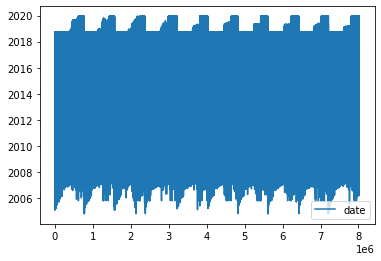

In [12]:
df.plot()

In [14]:
df.describe()

<ipython-input-14-ea8415b8a3ee>:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  df.describe()


,date
count,8021122
unique,7853102
top,2014-07-28 05:36:33
freq,7
first,2004-10-12 10:13:32
last,2019-12-13 15:51:19


In [15]:
bizData.shape

NameError: name 'bizData' is not defined

In [195]:
bizIds = set(revs.index)

In [208]:
cats = []
cat = 'bar'

with open(bizPATH, 'r') as infile:
        for line in infile:
            data = json.loads(line)
            if data['business_id'] in bizIds:
                if data['categories']:
                    if cat.lower() in data['categories'].lower():
                        for label in data['categories'].lower().split(', '):
    #                         if label not in cats:
                                cats.append(label)
    
cats = pd.DataFrame(cats)

In [216]:
cats.value_counts().nlargest(20)

restaurants               5453
nightlife                 4182
bars                      4167
food                      1839
american (traditional)    1388
american (new)            1175
sushi bars                 936
cocktail bars              803
japanese                   758
sports bars                729
pubs                       691
barbeque                   652
breakfast & brunch         636
juice bars & smoothies     613
wine bars                  611
burgers                    528
seafood                    496
sandwiches                 471
lounges                    443
asian fusion               429
dtype: int64

In [213]:
np.squeeze(list(cats.value_counts().nlargest(25).keys()))

array(['restaurants', 'nightlife', 'bars', 'food',
       'american (traditional)', 'american (new)', 'sushi bars',
       'cocktail bars', 'japanese', 'sports bars', 'pubs', 'barbeque',
       'breakfast & brunch', 'juice bars & smoothies', 'wine bars',
       'burgers', 'seafood', 'sandwiches', 'lounges', 'asian fusion',
       'steakhouses', 'coffee & tea', 'wine & spirits', 'beer',
       'event planning & services'], dtype='<U25')

In [218]:
# state

cats = []
cat = 'bar'

with open(bizPATH, 'r') as infile:
        for line in infile:
            data = json.loads(line)
#             if data['categories']:
#                 if cat.lower() in data['categories'].lower():

            if data['business_id'] in bizIds:
                cats.append(data['state'])
            
cats = pd.DataFrame(cats)

In [219]:
cats.value_counts().nlargest(20)

AZ    1646
NV    1340
ON    1144
NC     606
OH     504
PA     437
QC     223
WI     184
AB      67
SC      36
IL      10
dtype: int64

In [220]:
topLabels = ['restaurants', 'nightlife', 'bars', 'food',
       'american (traditional)', 'american (new)', 'sushi bars',
       'cocktail bars', 'japanese', 'sports bars', 'pubs', 'barbeque',
       'breakfast & brunch', 'juice bars & smoothies', 'wine bars',
       'burgers', 'seafood', 'sandwiches', 'lounges', 'asian fusion',
       'steakhouses', 'coffee & tea', 'wine & spirits', 'beer',
       'event planning & services']



topStates = ['AZ', 'NV', 'ON', 'OH', 'NC', 'PA', 'QC', 'AB', 'WI']

# topCities = [x.lower() for x in ['Las Vegas', 'Toronto', 'Phoenix', 'Charlotte', 'Scottsdale',
#        'Calgary', 'Pittsburgh', 'Montréal', 'Mesa', 'Henderson', 'Tempe',
#        'Chandler', 'Cleveland', 'Glendale', 'Gilbert', 'Madison',
#        'Mississauga', 'Peoria', 'Markham', 'North Las Vegas', 'Champaign',
#        'North York', 'Scarborough', 'Surprise', 'Richmond Hill']]

In [63]:
'2dNjePYVp2AVei4ZoSDaaA' in set(revs.index)

True

In [316]:
def businessData (revs, path=bizPATH,  topLabels=topLabels, topCities=topCities):
    
    # set is hashed thus faster
    bizIds = set(revs.index)
    
    bizData = []
    with open(path, 'r') as infile:
        for i, line in enumerate(infile):

            data = json.loads(line)

            if data['business_id'] in revs.index:
                business_id = data['business_id']
                review_count = data['review_count']
                
                if data['state'] in topStates:
                    state = data['state']
                else:
                    state = 'Other_State'
                
#                 if data['city'].lower() in topCities:
#                     city = data['city']
#                 else:
#                     city = 'Other_City'
                
                if data['categories']:    
                    flag = False
                    for label in data['categories'].lower().split(', '):
                        if label in topLabels:
                            flag = True
                    if flag:
                        categories = data['categories']
                    else:
                        categories = 'Other_Category'
                        
                        
                bizData.append([business_id, review_count, state, categories])
        
    df = pd.DataFrame(bizData, columns=['business_id', 'review_count', 'state', 'categories'])


    
    return df
    

In [317]:
df = businessData(revs)


In [318]:
df.set_index('business_id', drop=True, inplace=True)

In [319]:
df = pd.get_dummies(df, columns=['state'], prefix='S')

In [320]:
df[topLabels] = 0
df['Other_Category'] = 0

In [321]:
def label(row, topLabels):
    OC = True
    for l in row['categories'].lower().split(', '):
        if l in topLabels:
            row[l] = 1
            OC = False
    if OC:
        row['Other_Category'] = 1
        
    return row

df = df.apply(lambda row : label(row, topLabels), axis=1).drop('categories', axis = 1)

In [322]:
df.Other_Category.sum()

33

In [323]:
df.review_count = np.log(df.review_count)

In [287]:
df

,review_count,S_AB,S_AZ,S_NC,S_NV,S_OH,S_ON,S_Other_State,S_PA,S_QC,...,seafood,sandwiches,lounges,asian fusion,steakhouses,coffee & tea,wine & spirits,beer,event planning & services,Other_Category
business_id,,,,,,,,,,,,,,,,,,,,,
Mmd5WDFq9hHcQ3uClngGjQ,4.369448,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
cicPsia8Wj-DNRkmLbD_xg,4.510860,0,0,0,0,0,1,0,0,0,...,1,0,0,0,1,0,0,0,0,0
PlP0c_u3g-3LiWHpb2XnOQ,5.587249,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1aVqiz43klXaFJUUx0H5fw,5.509388,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
AtD6B83S4Mbmq0t7iDnUVA,7.040536,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8dK-8e006F_it5bNxTVlaQ,4.787492,0,0,0,0,1,0,0,0,0,...,0,1,0,0,0,0,0,0,1,0
kPwYdRKp1-W1-tUR8iylxw,4.543295,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
0hudPyuCBlKg79OwKBw-eQ,5.030438,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [249]:
df.review_count = df.review_count/df.review_count.max()

In [ ]:
    df.date = pd.to_datetime(pd.date).apply()

In [342]:
def addCovidFeature(bizData, path):
        

    bizIds = set(bizData.index)    

    with open(path) as infile:
        for i, line in enumerate(infile):

            data = json.loads(line)
            

            if data['business_id'] in bizIds:
                if data['highlights'] != 'FALSE':
                    bizData.loc[data['business_id'], 'hasHighlights'] = 1
                else:
                    bizData.loc[data['business_id'], 'hasHighlights'] = 0
                    
                if data['delivery or takeout'] != 'FALSE':
                    bizData.loc[data['business_id'], 'delivery or takeout'] = 1
                else:
                    bizData.loc[data['business_id'], 'delivery or takeout'] = 0
                    

In [343]:
# df = 
addCovidFeature(df, covidPATH)

In [329]:
df.hasHighlights.sum()/df.shape[0]

0.07890914958851057

In [344]:
df

,review_count,S_AB,S_AZ,S_NC,S_NV,S_OH,S_ON,S_Other_State,S_PA,S_QC,...,lounges,asian fusion,steakhouses,coffee & tea,wine & spirits,beer,event planning & services,Other_Category,hasHighlights,delivery or takeout
business_id,,,,,,,,,,,,,,,,,,,,,
Mmd5WDFq9hHcQ3uClngGjQ,4.369448,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0.0,0.0
cicPsia8Wj-DNRkmLbD_xg,4.510860,0,0,0,0,0,1,0,0,0,...,0,0,1,0,0,0,0,0,0.0,1.0
PlP0c_u3g-3LiWHpb2XnOQ,5.587249,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0.0,1.0
1aVqiz43klXaFJUUx0H5fw,5.509388,0,1,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0.0,0.0
AtD6B83S4Mbmq0t7iDnUVA,7.040536,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8dK-8e006F_it5bNxTVlaQ,4.787492,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,1,0,1.0,1.0
kPwYdRKp1-W1-tUR8iylxw,4.543295,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0.0,1.0
0hudPyuCBlKg79OwKBw-eQ,5.030438,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0.0,0.0


In [135]:
def userData(path, revs):
    
    userIds = set(revs.columns)
    
    uData = []
    with open(path, 'r') as infile:
        for i, line in enumerate(infile):
    
            data = json.loads(line)

            if data['user_id'] in userIds:
                
                user_id = data['user_id']
                review_count = data['review_count']
                yelping_since = data['yelping_since']
                friends = len(data['friends'].split())
                feedback = data['useful'] + data['funny'] + data['cool']
                fans = data['fans']
                if len(data['elite']) == 0:
                    elite = 0
                else:
                    elite = len(data['elite'].split(','))
                total_compliments = data['compliment_hot'] + data['compliment_more'] + data['compliment_profile'] + data['compliment_cute'] + data['compliment_list'] + data['compliment_note'] + data['compliment_plain'] + data['compliment_cool'] + data['compliment_funny'] + data['compliment_writer'] + data['compliment_photos']
                
                uData.append([user_id, review_count, yelping_since, friends, feedback, fans, elite, total_compliments])
                
    df = pd.DataFrame(uData, columns = ['user_id', 'review_count', 'yelping_since', 'friends', 'feedback', 'fans', 'elite', 'total_compliments'])
    df = df.set_index('user_id', drop=True)
    df.review_count = np.log(df.review_count)
    df. yelping_since = np.log(pd.to_datetime(df.yelping_since).apply(lambda x: (pd.to_datetime('2020-01-01') - x).days))
    df.friends = np.log(df.friends)
    df.feedback = np.log1p(df.feedback)
    df.fans = np.log1p(df.fans)
    df.total_compliments = np.log1p(df.total_compliments)
    
    
    return df

In [136]:
ud = userData(userPATH, revs)

In [137]:
df = ud

In [ ]:
df.review_count = np.log(df.review_count)

In [ ]:
df. yelping_since = np.log(pd.to_datetime(df.yelping_since).apply(lambda x: (pd.to_datetime('2020-01-01') - x).days))

In [ ]:
    df.friends = np.log(df.friends)

In [127]:
df.feedback = np.log1p(df.feedback)

In [129]:
df.fans = np.log1p(df.fans)

In [133]:
df.total_compliments = np.log1p(df.total_compliments)

In [138]:
df.describe()

,review_count,yelping_since,friends,feedback,fans,elite,total_compliments
count,12680.000000,12680.000000,12680.000000,12680.000000,12680.000000,12680.000000,12680.000000
mean,4.687685,7.607687,3.825362,5.223398,1.724034,1.450237,2.654791
std,0.916505,0.505927,1.993048,1.615349,1.350451,2.034690,1.819899
min,2.397895,3.951244,0.000000,0.000000,0.000000,0.000000,0.000000
25%,4.043051,7.342132,2.564949,4.174387,0.693147,0.000000,1.386294
50%,4.564348,7.687539,4.276666,5.049856,1.609438,1.000000,2.397895
75%,5.205377,7.979681,5.257495,6.079933,2.564949,2.000000,3.663562
max,9.455011,8.610684,9.072916,12.948998,7.908019,13.000000,11.248947


In [68]:
time = pd.to_datetime('2018-02-03')

In [69]:
time_now = pd.to_datetime('2020-01-01')

In [76]:
(time_now - time).days

int

In [ ]:
data = pd.read_json(userPATH, lines=True)

In [17]:
revs.columns

Index(['--2HUmLkcNHZp0xw6AMBPg', '--BumyUHiO_7YsHurb9Hkw',
       '--Nnm_506G_p8MxAOQna5w', '--Qh8yKWAvIP4V4K8ZPfHA',
       '--YhjyV-ce1nFLYxP49C5A', '--ZNfWKj1VyVElRx6-g1fg',
       '--cd_gA-9Q8gM9P2cTxEsQ', '-0-hVEpwWEcJLJoGq3rE3g',
       '-0Xu57zrI3Rxi8wGZsnWKQ', '-0b84SUGVN0YkG5j2MCmBw',
       ...
       'zy4A7504SezncCAcotMv4g', 'zyMB50UtmEuQf-1VUKxZxQ',
       'zyebSPCZLUZHapi-dSHU5Q', 'zyg4-MFtfPWmwucVazSjfw',
       'zyh_AzbO1JNnhywem3hUPg', 'zynfOy36AZ0WsoGUYAjQaA',
       'zz25_Dsf99KnwTpdl4-PDQ', 'zzKsgIF472IyDpJxmHDIpw',
       'zzmhLxcZ4XZQyz95c_KbOA', 'zzo--VpSQh8PpsGVeMC1dQ'],
      dtype='object', name='user_id', length=12680)

In [107]:
file = open(userPATH)

In [108]:
data = json.loads(file.readline())

In [115]:
len(data['elite'].split(','))

1

In [121]:
len(data['elite'])

0

In [29]:
data['useful'] + data['funny'] + data['cool']  data['fans']

1080

In [36]:
len(data['elite'].split(','))

6

In [35]:
data['elite']

'2008,2009,2010,2011,2012,2013'

In [38]:
data['compliment_hot'] + data['compliment_more'] + data['compliment_profile'] + data['compliment_cute'] + data['compliment_list'] + data['compliment_note'] + data['compliment_plain'] + data['compliment_cool'] + data['compliment_funny'] + data['compliment_writer'] + data['compliment_photos']

270